In [5]:
%load_ext autoreload
%autoreload 2

# ref:
- https://radimrehurek.com/gensim/models/ldamodel.html

In [ ]:
# set Thaifont

import urllib.request
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# Download Noto Sans that includes both Thai and Latin
urllib.request.urlretrieve(
    'https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSans/NotoSans-Regular.ttf',
    'NotoSans.ttf'
)

fm.fontManager.addfont('NotoSans.ttf')

# Use multiple fonts - Thai font for Thai text, DejaVu for numbers/English
plt.rcParams['font.family'] = ['Noto Sans Thai', 'DejaVu Sans']
plt.rcParams['font.sans-serif'] = ['Noto Sans Thai', 'DejaVu Sans']

# Set up

In [6]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [7]:
import os

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_SESSION_TOKEN = os.getenv("AWS_SESSION_TOKEN", None)

In [8]:
import boto3

s3_client = boto3.client("s3", region_name="ap-southeast-1", aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY, aws_session_token=AWS_SESSION_TOKEN)
s3_client.list_buckets()["ResponseMetadata"]['HTTPStatusCode']

200

In [9]:
import torch
torch.cuda.is_available()

False

# Test

In [10]:
import pandas as pd

data = {
    "documents": [
        "วันนี้อากาศดีมาก อยากไปเที่ยวทะเล",
        "ปัญญาประดิษฐ์กำลังเปลี่ยนแปลงโลกและเทคโนโลยี",
        "ฉันชอบกินอาหารไทยโดยเฉพาะผัดไทยและต้มยำกุ้ง",
        "เทคโนโลยีและนวัตกรรมช่วยให้ชีวิตง่ายขึ้น",
        "อยากไปเที่ยวภูเขากับเพื่อนในวันหยุด"
    ]
}

df = pd.DataFrame(data)
texts = df["documents"].tolist()
df

,documents
0,วันนี้อากาศดีมาก อยากไปเที่ยวทะเล
1,ปัญญาประดิษฐ์กำลังเปลี่ยนแปลงโลกและเทคโนโลยี
2,ฉันชอบกินอาหารไทยโดยเฉพาะผัดไทยและต้มยำกุ้ง
3,เทคโนโลยีและนวัตกรรมช่วยให้ชีวิตง่ายขึ้น
4,อยากไปเที่ยวภูเขากับเพื่อนในวันหยุด


In [11]:
from pythainlp import word_tokenize
from pythainlp.corpus.common import thai_stopwords
import re
from typing import Literal
stopwords = set(thai_stopwords())

class Tokenizer:
    def __init__(self, stopwords:set, engine:Literal["newmm", "attacut"]="newmm"):
        self.stopwords = stopwords
        self.engine = engine
        self.message()

    def message(self,):
        print(f"Number of stopwords: {len(self.stopwords)}")
        print(f"Tokenizer engine: {self.engine}")

    def __call__(self, text):
        return self.run(text)

    def clean(self, text):
        return re.sub(r"[^ก-๙a-zA-Z\s]", "", text)

    def tokenize(self, text):
        return word_tokenize(text, engine=self.engine, keep_whitespace=False)

    def remove_stopwords(self, tokens):
        return [t for t in tokens if t not in stopwords and len(t) > 1]

    def run(self, text):
        text = self.clean(text)
        tokens = self.tokenize(text)
        return self.remove_stopwords(tokens)

tokenizer = Tokenizer(stopwords=stopwords, engine="newmm")

processed_texts = [tokenizer(doc) for doc in texts]
print(processed_texts)

Number of stopwords: 1030
Tokenizer engine: newmm
[['อากาศ', 'ดีมาก', 'ไปเที่ยว', 'ทะเล'], ['ปัญญาประดิษฐ์', 'โลก', 'เทคโนโลยี'], ['ชอบ', 'กิน', 'อาหาร', 'ไทย', 'โดยเฉพาะ', 'ผัดไทย', 'ต้มยำกุ้ง'], ['เทคโนโลยี', 'นวัตกรรม', 'ชีวิต'], ['ไปเที่ยว', 'ภูเขา', 'เพื่อน', 'วันหยุด']]


In [12]:
from gensim import corpora

dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

In [13]:
dictionary.token2id

{'ดีมาก': 0,
 'ทะเล': 1,
 'อากาศ': 2,
 'ไปเที่ยว': 3,
 'ปัญญาประดิษฐ์': 4,
 'เทคโนโลยี': 5,
 'โลก': 6,
 'กิน': 7,
 'ชอบ': 8,
 'ต้มยำกุ้ง': 9,
 'ผัดไทย': 10,
 'อาหาร': 11,
 'โดยเฉพาะ': 12,
 'ไทย': 13,
 'ชีวิต': 14,
 'นวัตกรรม': 15,
 'ภูเขา': 16,
 'วันหยุด': 17,
 'เพื่อน': 18}

In [14]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)],
 [(5, 1), (14, 1), (15, 1)],
 [(3, 1), (16, 1), (17, 1), (18, 1)]]

In [15]:
for doc_bow in corpus:
    words_in_doc = [(dictionary[id], count) for id, count in doc_bow]
    print(words_in_doc)

[('ดีมาก', 1), ('ทะเล', 1), ('อากาศ', 1), ('ไปเที่ยว', 1)]
[('ปัญญาประดิษฐ์', 1), ('เทคโนโลยี', 1), ('โลก', 1)]
[('กิน', 1), ('ชอบ', 1), ('ต้มยำกุ้ง', 1), ('ผัดไทย', 1), ('อาหาร', 1), ('โดยเฉพาะ', 1), ('ไทย', 1)]
[('เทคโนโลยี', 1), ('ชีวิต', 1), ('นวัตกรรม', 1)]
[('ไปเที่ยว', 1), ('ภูเขา', 1), ('วันหยุด', 1), ('เพื่อน', 1)]


In [16]:
from gensim.models import LdaModel

num_topics=4

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,        # try adjusting this
    random_state=55,
    passes=20,
    alpha='auto'
)

In [17]:
for idx, topic in lda_model.print_topics(-1):
    print(f"หัวข้อที่ {idx}: {topic}\n")

หัวข้อที่ 0: 0.161*"โลก" + 0.161*"ปัญญาประดิษฐ์" + 0.161*"เทคโนโลยี" + 0.032*"ไปเที่ยว" + 0.032*"วันหยุด" + 0.032*"ทะเล" + 0.032*"ชีวิต" + 0.032*"ภูเขา" + 0.032*"เพื่อน" + 0.032*"นวัตกรรม"

หัวข้อที่ 1: 0.106*"เทคโนโลยี" + 0.106*"ไปเที่ยว" + 0.106*"เพื่อน" + 0.106*"ภูเขา" + 0.106*"วันหยุด" + 0.106*"นวัตกรรม" + 0.106*"ชีวิต" + 0.021*"ดีมาก" + 0.021*"ทะเล" + 0.021*"อากาศ"

หัวข้อที่ 2: 0.079*"ต้มยำกุ้ง" + 0.079*"ไทย" + 0.079*"โดยเฉพาะ" + 0.079*"อาหาร" + 0.079*"ผัดไทย" + 0.079*"ชอบ" + 0.079*"กิน" + 0.079*"ดีมาก" + 0.079*"อากาศ" + 0.079*"ทะเล"

หัวข้อที่ 3: 0.053*"เทคโนโลยี" + 0.053*"ไปเที่ยว" + 0.053*"อากาศ" + 0.053*"ทะเล" + 0.053*"วันหยุด" + 0.053*"ปัญญาประดิษฐ์" + 0.053*"ชีวิต" + 0.053*"นวัตกรรม" + 0.053*"โลก" + 0.053*"เพื่อน"



In [18]:
lda_model.print_topics(-1)

[(0,
  '0.161*"โลก" + 0.161*"ปัญญาประดิษฐ์" + 0.161*"เทคโนโลยี" + 0.032*"ไปเที่ยว" + 0.032*"วันหยุด" + 0.032*"ทะเล" + 0.032*"ชีวิต" + 0.032*"ภูเขา" + 0.032*"เพื่อน" + 0.032*"นวัตกรรม"'),
 (1,
  '0.106*"เทคโนโลยี" + 0.106*"ไปเที่ยว" + 0.106*"เพื่อน" + 0.106*"ภูเขา" + 0.106*"วันหยุด" + 0.106*"นวัตกรรม" + 0.106*"ชีวิต" + 0.021*"ดีมาก" + 0.021*"ทะเล" + 0.021*"อากาศ"'),
 (2,
  '0.079*"ต้มยำกุ้ง" + 0.079*"ไทย" + 0.079*"โดยเฉพาะ" + 0.079*"อาหาร" + 0.079*"ผัดไทย" + 0.079*"ชอบ" + 0.079*"กิน" + 0.079*"ดีมาก" + 0.079*"อากาศ" + 0.079*"ทะเล"'),
 (3,
  '0.053*"เทคโนโลยี" + 0.053*"ไปเที่ยว" + 0.053*"อากาศ" + 0.053*"ทะเล" + 0.053*"วันหยุด" + 0.053*"ปัญญาประดิษฐ์" + 0.053*"ชีวิต" + 0.053*"นวัตกรรม" + 0.053*"โลก" + 0.053*"เพื่อน"')]

In [19]:
dictionary

In [20]:
def gensim_predict_topic(text, model, dictionary, tokenizer, return_all_topics=True):
    tokens = tokenizer(text)
    bow = dictionary.doc2bow(tokens)
    topics = model.get_document_topics(bow)
    if return_all_topics:
        return topics
    if not topics:
        return None, 0
    main_topic_id, prob = max(topics, key=lambda x: x[1])
    return main_topic_id, prob

In [21]:
texts[0]

'วันนี้อากาศดีมาก อยากไปเที่ยวทะเล'

In [22]:
gensim_predict_topic(texts[0], lda_model, dictionary, tokenizer, return_all_topics=False)

(2, 0.9474282)

In [23]:
lda_model.print_topics(-1)

[(0,
  '0.161*"โลก" + 0.161*"ปัญญาประดิษฐ์" + 0.161*"เทคโนโลยี" + 0.032*"ไปเที่ยว" + 0.032*"วันหยุด" + 0.032*"ทะเล" + 0.032*"ชีวิต" + 0.032*"ภูเขา" + 0.032*"เพื่อน" + 0.032*"นวัตกรรม"'),
 (1,
  '0.106*"เทคโนโลยี" + 0.106*"ไปเที่ยว" + 0.106*"เพื่อน" + 0.106*"ภูเขา" + 0.106*"วันหยุด" + 0.106*"นวัตกรรม" + 0.106*"ชีวิต" + 0.021*"ดีมาก" + 0.021*"ทะเล" + 0.021*"อากาศ"'),
 (2,
  '0.079*"ต้มยำกุ้ง" + 0.079*"ไทย" + 0.079*"โดยเฉพาะ" + 0.079*"อาหาร" + 0.079*"ผัดไทย" + 0.079*"ชอบ" + 0.079*"กิน" + 0.079*"ดีมาก" + 0.079*"อากาศ" + 0.079*"ทะเล"'),
 (3,
  '0.053*"เทคโนโลยี" + 0.053*"ไปเที่ยว" + 0.053*"อากาศ" + 0.053*"ทะเล" + 0.053*"วันหยุด" + 0.053*"ปัญญาประดิษฐ์" + 0.053*"ชีวิต" + 0.053*"นวัตกรรม" + 0.053*"โลก" + 0.053*"เพื่อน"')]

In [24]:
texts[0]

'วันนี้อากาศดีมาก อยากไปเที่ยวทะเล'

In [25]:
tokenizer(texts[0])

['อากาศ', 'ดีมาก', 'ไปเที่ยว', 'ทะเล']

In [26]:
lda_model.show_topic(2, topn=20)

[('ต้มยำกุ้ง', 0.07936507),
 ('ไทย', 0.07936507),
 ('โดยเฉพาะ', 0.07936504),
 ('อาหาร', 0.07936504),
 ('ผัดไทย', 0.07936501),
 ('ชอบ', 0.07936501),
 ('กิน', 0.07936498),
 ('ดีมาก', 0.07936476),
 ('อากาศ', 0.07936466),
 ('ทะเล', 0.07936458),
 ('ไปเที่ยว', 0.07936195),
 ('เทคโนโลยี', 0.015873967),
 ('ชีวิต', 0.015873656),
 ('นวัตกรรม', 0.015873628),
 ('ปัญญาประดิษฐ์', 0.015873587),
 ('วันหยุด', 0.015873542),
 ('โลก', 0.015873525),
 ('ภูเขา', 0.015873516),
 ('เพื่อน', 0.015873477)]

In [27]:
topic_word_matrix = lda_model.get_topics()  # shape = (num_topics, vocab_size)
topic_word_matrix.shape

(4, 19)

In [28]:
topic_word_matrix

array([[0.03225898, 0.03225919, 0.03225905, 0.03225949, 0.16129144,
        0.16127191, 0.16129166, 0.03225896, 0.03225899, 0.03225887,
        0.03225898, 0.03225893, 0.03225891, 0.03225891, 0.03225916,
        0.03225907, 0.03225908, 0.0322592 , 0.03225908],
       [0.02127689, 0.02127689, 0.02127687, 0.10638495, 0.02127679,
        0.10639383, 0.02127673, 0.02127662, 0.0212766 , 0.0212766 ,
        0.02127665, 0.0212766 , 0.02127662, 0.02127661, 0.10637997,
        0.10638008, 0.10638027, 0.10638008, 0.1063803 ],
       [0.07936476, 0.07936458, 0.07936466, 0.07936195, 0.01587359,
        0.01587397, 0.01587353, 0.07936498, 0.07936501, 0.07936507,
        0.07936501, 0.07936504, 0.07936504, 0.07936507, 0.01587366,
        0.01587363, 0.01587352, 0.01587354, 0.01587348],
       [0.05263148, 0.05263172, 0.05263172, 0.05263222, 0.05263164,
        0.05263224, 0.05263158, 0.05263148, 0.0526314 , 0.05263136,
        0.05263129, 0.05263139, 0.05263135, 0.0526313 , 0.0526316 ,
        0.052

In [29]:
lookup = pd.DataFrame(topic_word_matrix, columns=dictionary.token2id)
lookup

,ดีมาก,ทะเล,อากาศ,ไปเที่ยว,ปัญญาประดิษฐ์,เทคโนโลยี,โลก,กิน,ชอบ,ต้มยำกุ้ง,ผัดไทย,อาหาร,โดยเฉพาะ,ไทย,ชีวิต,นวัตกรรม,ภูเขา,วันหยุด,เพื่อน
0,0.032259,0.032259,0.032259,0.032259,0.161291,0.161272,0.161292,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259
1,0.021277,0.021277,0.021277,0.106385,0.021277,0.106394,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.106380,0.106380,0.106380,0.106380,0.106380
2,0.079365,0.079365,0.079365,0.079362,0.015874,0.015874,0.015874,0.079365,0.079365,0.079365,0.079365,0.079365,0.079365,0.079365,0.015874,0.015874,0.015874,0.015874,0.015873
3,0.052631,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052631,0.052631,0.052631,0.052631,0.052631,0.052631,0.052631,0.052632,0.052632,0.052631,0.052632,0.052632


In [50]:
lookup.head()

,ดีมาก,ทะเล,อากาศ,ไปเที่ยว,ปัญญาประดิษฐ์,เทคโนโลยี,โลก,กิน,ชอบ,ต้มยำกุ้ง,ผัดไทย,อาหาร,โดยเฉพาะ,ไทย,ชีวิต,นวัตกรรม,ภูเขา,วันหยุด,เพื่อน
0,0.032259,0.032259,0.032259,0.032259,0.161291,0.161272,0.161292,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259,0.032259
1,0.021277,0.021277,0.021277,0.106385,0.021277,0.106394,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.106380,0.106380,0.106380,0.106380,0.106380
2,0.079365,0.079365,0.079365,0.079362,0.015874,0.015874,0.015874,0.079365,0.079365,0.079365,0.079365,0.079365,0.079365,0.079365,0.015874,0.015874,0.015874,0.015874,0.015873
3,0.052631,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052631,0.052631,0.052631,0.052631,0.052631,0.052631,0.052631,0.052632,0.052632,0.052631,0.052632,0.052632


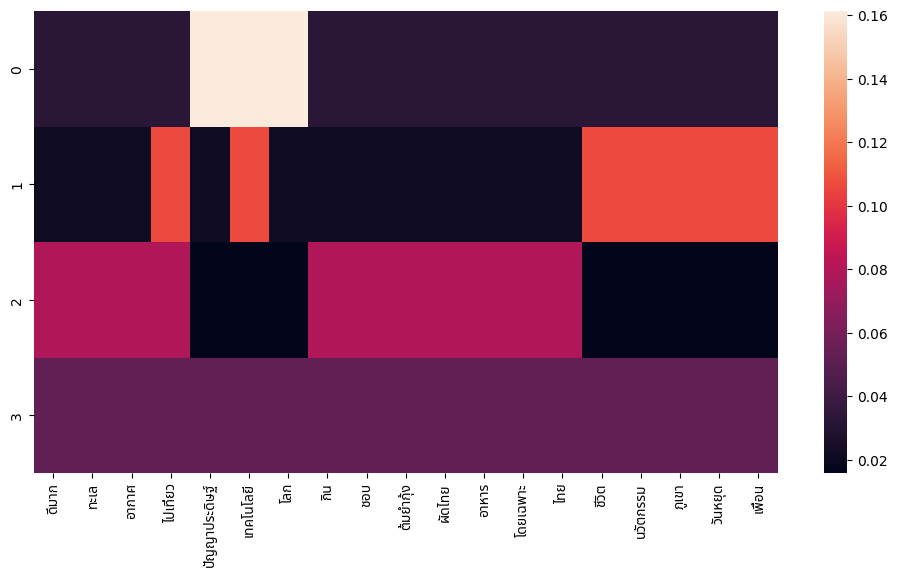

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.heatmap(lookup);

In [53]:
tokens = tokenizer(texts[0])
bow = dictionary.doc2bow(tokens)
# lookup.loc[:, tokens]
topics = lda_model.get_document_topics(bow)
top_topic = max(topics, key=lambda x: x[1])
print(top_topic)

(2, 0.9474282)


In [54]:
bow, tokens

([(0, 1), (1, 1), (2, 1), (3, 1)], ['อากาศ', 'ดีมาก', 'ไปเที่ยว', 'ทะเล'])

In [55]:
lookup.loc[:, tokens]

,อากาศ,ดีมาก,ไปเที่ยว,ทะเล
0,0.032259,0.032259,0.032259,0.032259
1,0.021277,0.021277,0.106385,0.021277
2,0.079365,0.079365,0.079362,0.079365
3,0.052632,0.052631,0.052632,0.052632


In [56]:
topics

[(0, 0.016297901), (1, 0.028862529), (2, 0.9474282)]

In [57]:
lookup.loc[:, tokens].sum(axis=1) / lookup.loc[:, tokens].sum(axis=1).sum()

0    0.155985
1    0.205764
2    0.383755
3    0.254495
dtype: float32

In [58]:
lookup.loc[:, tokens].sum(axis=1)

0    0.129037
1    0.170216
2    0.317456
3    0.210527
dtype: float32

In [59]:
print(lookup)

      ดีมาก      ทะเล     อากาศ  ไปเที่ยว  ปัญญาประดิษฐ์  เทคโนโลยี       โลก  \
0  0.032259  0.032259  0.032259  0.032259       0.161291   0.161272  0.161292   
1  0.021277  0.021277  0.021277  0.106385       0.021277   0.106394  0.021277   
2  0.079365  0.079365  0.079365  0.079362       0.015874   0.015874  0.015874   
3  0.052631  0.052632  0.052632  0.052632       0.052632   0.052632  0.052632   

        กิน       ชอบ  ต้มยำกุ้ง    ผัดไทย     อาหาร  โดยเฉพาะ       ไทย  \
0  0.032259  0.032259   0.032259  0.032259  0.032259  0.032259  0.032259   
1  0.021277  0.021277   0.021277  0.021277  0.021277  0.021277  0.021277   
2  0.079365  0.079365   0.079365  0.079365  0.079365  0.079365  0.079365   
3  0.052631  0.052631   0.052631  0.052631  0.052631  0.052631  0.052631   

      ชีวิต  นวัตกรรม     ภูเขา   วันหยุด    เพื่อน  
0  0.032259  0.032259  0.032259  0.032259  0.032259  
1  0.106380  0.106380  0.106380  0.106380  0.106380  
2  0.015874  0.015874  0.015874  0.015874  0.015873

In [60]:
bow = dictionary.doc2bow(tokenizer(texts[0]))
bow, tokenizer(texts[0])

([(0, 1), (1, 1), (2, 1), (3, 1)], ['อากาศ', 'ดีมาก', 'ไปเที่ยว', 'ทะเล'])

In [61]:
dictionary.token2id

{'ดีมาก': 0,
 'ทะเล': 1,
 'อากาศ': 2,
 'ไปเที่ยว': 3,
 'ปัญญาประดิษฐ์': 4,
 'เทคโนโลยี': 5,
 'โลก': 6,
 'กิน': 7,
 'ชอบ': 8,
 'ต้มยำกุ้ง': 9,
 'ผัดไทย': 10,
 'อาหาร': 11,
 'โดยเฉพาะ': 12,
 'ไทย': 13,
 'ชีวิต': 14,
 'นวัตกรรม': 15,
 'ภูเขา': 16,
 'วันหยุด': 17,
 'เพื่อน': 18}

In [62]:
lookup.loc[:,tokenizer(texts[0])].sum(axis=1)

0    0.129037
1    0.170216
2    0.317456
3    0.210527
dtype: float32

In [63]:
(lookup>0).sum(axis=1)

0    19
1    19
2    19
3    19
dtype: int64

In [64]:
topic_stats = []
for i in range(lda_model.num_topics):
    words = lda_model.show_topic(i, topn=10)
    nonzero_count = (lda_model.get_topics()[i] > 0).sum()
    topic_stats.append((i, nonzero_count, [w for w, p in words]))

df_stats = pd.DataFrame(topic_stats, columns=["topic", "num_words", "top_words"])
df_stats

,topic,num_words,top_words
0,0,19,"[โลก, ปัญญาประดิษฐ์, เทคโนโลยี, ไปเที่ยว, วันห..."
1,1,19,"[เทคโนโลยี, ไปเที่ยว, เพื่อน, ภูเขา, วันหยุด, ..."
2,2,19,"[ต้มยำกุ้ง, ไทย, โดยเฉพาะ, อาหาร, ผัดไทย, ชอบ,..."
3,3,19,"[เทคโนโลยี, ไปเที่ยว, อากาศ, ทะเล, วันหยุด, ปั..."


In [65]:
dir(dictionary)

['__abstractmethods__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_adapt_by_suffix',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'add_documents',
 'add_lifecycle_event',
 'cfs',
 'compactify',
 'dfs',
 'doc2bow',
 'doc2idx',
 'filter_extremes',
 'filter_n_most_frequent',
 'filter_tokens',
 'from_corpus',
 'from_documents',
 'get',
 'id2token',
 'items',
 'iteritems',
 'iterkeys',
 'itervalues',
 'keys',
 'lifecycle_events',
 'load',
 'load_from_text',
 'merge_with',
 'most_common',
 'num_docs',
 'num_nnz',
 'num

In [66]:
dictionary.id2token

{0: 'ดีมาก',
 1: 'ทะเล',
 2: 'อากาศ',
 3: 'ไปเที่ยว',
 4: 'ปัญญาประดิษฐ์',
 5: 'เทคโนโลยี',
 6: 'โลก',
 7: 'กิน',
 8: 'ชอบ',
 9: 'ต้มยำกุ้ง',
 10: 'ผัดไทย',
 11: 'อาหาร',
 12: 'โดยเฉพาะ',
 13: 'ไทย',
 14: 'ชีวิต',
 15: 'นวัตกรรม',
 16: 'ภูเขา',
 17: 'วันหยุด',
 18: 'เพื่อน'}

In [67]:
dictionary.token2id

{'ดีมาก': 0,
 'ทะเล': 1,
 'อากาศ': 2,
 'ไปเที่ยว': 3,
 'ปัญญาประดิษฐ์': 4,
 'เทคโนโลยี': 5,
 'โลก': 6,
 'กิน': 7,
 'ชอบ': 8,
 'ต้มยำกุ้ง': 9,
 'ผัดไทย': 10,
 'อาหาร': 11,
 'โดยเฉพาะ': 12,
 'ไทย': 13,
 'ชีวิต': 14,
 'นวัตกรรม': 15,
 'ภูเขา': 16,
 'วันหยุด': 17,
 'เพื่อน': 18}

In [68]:
import numpy as np

# phi: topic-word matrix shape (num_topics, vocab_size)
phi = lda_model.get_topics()          # P(word | topic)
vocab = dictionary.token2id           # mapping word->id
num_topics = phi.shape[0]

# alpha: prior. lda_model.alpha may be scalar or array
alpha = lda_model.alpha
if np.isscalar(alpha):
    topic_prior = np.ones(num_topics) * alpha
else:
    topic_prior = np.array(alpha)

# Convert prior to something proportional to P(z=k)
# Use (alpha) as prior weight; for log use log(alpha) (add small eps)
eps = 1e-12
log_prior = np.log(topic_prior + eps)

# bow is list of (word_id, count)
def infer_topic_probs_from_bow(bow):
    # compute log-score for each topic
    log_s = np.array(log_prior, dtype=float)  # shape (num_topics,)
    for wid, count in bow:
        # P(word|topic) for all topics: phi[:, wid]
        # Avoid zeros: clip
        probs = np.clip(phi[:, wid], 1e-12, None)
        log_s += count * np.log(probs)
    # normalize in log space -> get probabilities
    # subtract max for numerical stability
    log_s -= log_s.max()
    s = np.exp(log_s)
    probs = s / s.sum()
    return probs

# Example: compute and compare to gensim result
probs = infer_topic_probs_from_bow(bow)

In [69]:
probs

array([0.01345266, 0.02252549, 0.92067546, 0.04334639])

In [70]:
gensim_predict_topic(texts[0], lda_model, dictionary, tokenizer, return_all_topics=False)

(2, 0.9474282)

In [71]:
topics

[(0, 0.016297901), (1, 0.028862529), (2, 0.9474282)]

In [72]:
import numpy as np
from gensim import corpora

def predict_topic_distribution(lda_model, dictionary, tokens):
    """
    Manually compute topic probabilities for a new document.
    Based on P(z | d) ∝ P(z) * ∏_w P(w | z)^{n_w,d}
    """
    # Convert tokens → bag of words
    bow = dictionary.doc2bow(tokens)

    # Get topic-word matrix (num_topics x vocab_size)
    topic_word_prob = lda_model.get_topics()  # P(w|z)
    num_topics = topic_word_prob.shape[0]
    
    # Topic prior (from alpha)
    alpha = np.array(lda_model.alpha)
    log_prior = np.log(alpha / alpha.sum())
    
    # Initialize log-probabilities
    log_prob = np.copy(log_prior)

    # For each word in the document
    for word_id, count in bow:
        # Skip unseen words
        if word_id >= topic_word_prob.shape[1]:
            continue
        word_probs = topic_word_prob[:, word_id] + 1e-12  # avoid log(0)
        log_prob += count * np.log(word_probs)
    
    # Convert back from log space → normal probability
    prob = np.exp(log_prob - np.max(log_prob))  # avoid overflow
    prob /= prob.sum()
    
    return prob


In [73]:
tokens = ['อากาศ', 'ดีมาก', 'ไปเที่ยว', 'ทะเล']

manual_prob = predict_topic_distribution(lda_model, dictionary, tokens)
gensim_prob = np.array([p for _, p in lda_model.get_document_topics(dictionary.doc2bow(tokens), minimum_probability=0)])

print("Manual:", manual_prob)
print("Gensim:", gensim_prob)


Manual: [0.01345267 0.02252549 0.9206754  0.04334642]
Gensim: [0.0162979  0.02886254 0.9474282  0.00741135]


In [75]:
dir(lda_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'add_lifecycle_event',
 'alpha',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'lifecycle_events',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'num

In [78]:
lda_model.alpha, lda_model.eta, lda_model.gamma_threshold

(array([0.07109185, 0.12580414, 0.1328121 , 0.0323285 ], dtype=float32),
 array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
        0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25], dtype=float32),
 0.001)

[(0, 1), (1, 1), (2, 1), (3, 1)]

In [90]:
lda_model.get_document_topics(bow=dictionary.doc2bow(tokenizer(texts[0])), minimum_probability=0)

[(0, 0.016297901), (1, 0.028862529), (2, 0.9474282), (3, 0.007411348)]

In [92]:
import numpy as np

num_topics = lda_model.num_topics
dense_probs = np.zeros(num_topics)

topic_probs = lda_model.get_document_topics(bow)
print(topic_probs)
# Example output: [(0, 0.05), (1, 0.10), (2, 0.85)]

for topic_id, prob in topic_probs:
    dense_probs[topic_id] = prob

print(dense_probs)
# [0.05, 0.10, 0.85, 0.0, ...]


[(0, 0.016297901), (1, 0.028862553), (2, 0.9474282)]
[0.0162979  0.02886255 0.94742823 0.        ]
